# Tutorial (Structured Data Processing)

:::{warning}
This page is under construction and not finished yet. Do not use it.
:::

(Last updated: Feb 11, 2023)

This tutorial will familiarize you with the data science pipeline of processing structured data, using a real-world example of building models to predict and explain the presence of bad smell events in Pittsburgh using air quality and weather data (as indicated in the following figure). The models are used to send push notifications about bad smell events to inform citizens, as well as to explain local pollution patterns to inform stakeholders.

\
<img src="../../../assets/images/smellpgh-predict.png" style="max-width: 700px;">

\
The scenario is in the mext section of this tutorial, and more details is in the introduction section of the [Smell Pittsburgh paper](https://doi.org/10.1145/3369397). We will use the [same dataset as used in the Smell Pittsburgh paper](https://github.com/CMU-CREATE-Lab/smell-pittsburgh-prediction/tree/master/dataset/v1) as an example of structured data. During this tutorial, we will explain what the variables in the dataset mean and also guide you through model building.

## Scenario

Local citizens in Pittsburgh are organizing communities to advocate for changes in air pollution regulations. Their goal is to investigate the air pollution patterns in the city to understand the potential sources related to the bad odor. The communities rely on the Smell Pittsburgh application (as indicated in the figure below) to collect smell reports from citizens that live in the Pittsburgh region. Also, there are air quality and weather monitoring stations in the Pittsburgh city region that provide sensor measurements, including common air pollutants and wind information.

\
<img src="../../../assets/images/smellpgh-ui.png" style="max-width: 700px;">

\
You work in a data science team to develop models to map the sensor data to bad smell events. Your team has been working with the Pittsburgh local citizens closely for a long time, and therefore you know the meaning of each variable in the feature set that is used to train the machine learning model. The Pittsburgh community needs your help timely to analyze the data that can help them present evidence of air pollution to the municipality and explain the patterns to the general public.

## Packages and Answers

We put all the packages that are needed for this tutorial below:

In [1]:
import pandas as pd
from os.path import isfile, join
from os import listdir

The code block below contains answers for the assignments in this tutorial. **Do not check the answers in the next cell before practicing the tasks.**

In [2]:
def check_answer_df(df_result, df_answer, n=1):
    """
    This function checks if two output dataframes are the same.
    """
    try:
        assert df_answer.equals(df_result)
        print("Test case %d passed." % n)
    except:
        print("Test case %d failed." % n)
        print("")
        print("Your output is:")
        print(df_result)
        print("")
        print("Expected output is:")
        print(df_answer)
        

def answer_preprocess_smell(df):
    """
    This function is the answer of task 4.
    """
    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)
    
    # Drop the columns that we do not need.
    df = df.drop(columns=["feelings_symptoms", "smell_description", "zipcode"])
    
    # Select only the reports within the range of 3 and 5.
    df = df[(df["smell_value"]>=3)&(df["smell_value"]<=5)]
    
    # Convert the timestamp to datetime.
    df.index = pd.to_datetime(df.index, unit="s", utc=True)

    # Resample the timestamps by hour and sum up all the values.
    # Because we want data from the past, so label need to be "right".
    df = df.resample("60Min", label="right").sum()
    
    # Fill in the missing data with value 0.
    df = df.fillna(0)
    return df


def answer_preprocess_sensor(df_list):
    """
    This function is the answer of task 5.
    """
    # Resample all the data frames.
    df_resample_list = []
    for df in df_list:
        # Convert the timestamp to datetime.
        df.index = pd.to_datetime(df.index, unit="s", utc=True)
        # Resample the timestamps by hour and average all the values.
        df_resample_list.append(df.resample("60Min", label="right").mean())
    
    # Merge all data frames.
    df = df_resample_list.pop(0)
    index_name = df.index.name
    while len(df_resample_list) != 0:
        # We need to use outer merging since we want to preserve data from both data frames.
        df = pd.merge_ordered(df, df_resample_list.pop(0), on=df.index.name, how="outer", fill_method=None)
        # Move the datetime column to index
        df = df.set_index(index_name)

    # Fill in the missing data with value -1.
    df = df.fillna(-1)
    return df

## Task 4: Preprocess Smell Data

In this task, we will preprocess the smell data. First, we need to load the raw smell data.

In [3]:
smell_raw = pd.read_csv("../../../assets/datasets/smellpgh-v1/smell_raw.csv").set_index("EpochTime")
smell_raw

,feelings_symptoms,smell_description,smell_value,zipcode
EpochTime,,,,
1477935134,NaN,NaN,1,15221
1477956180,NaN,Woodsmoke,2,15218
1477956293,NaN,Wood smoke,3,15218
1477973293,"Eye irritation, nose burns, headache, woke me up",Industrial,5,15207
1478001989,NaN,Industrial smoke,2,15213
...,...,...,...,...
1538248172,NaN,Sour sewage,3,15213
1538255258,Coughing,Smoke,2,15104
1538268796,NaN,Like a burning candle,3,15232


Next, we need to resample the smell data so that they can be used for modeling. Our goal is to have a dataframe that looks like the following:

In [4]:
df_smell = answer_preprocess_smell(smell_raw)
df_smell

,smell_value
EpochTime,
2016-11-01 00:00:00+00:00,3
2016-11-01 01:00:00+00:00,0
2016-11-01 02:00:00+00:00,0
2016-11-01 03:00:00+00:00,0
2016-11-01 04:00:00+00:00,0
...,...
2018-09-30 01:00:00+00:00,3
2018-09-30 02:00:00+00:00,0
2018-09-30 03:00:00+00:00,0


**Your task (which is your assignment) is to write a function to do the following:**
- First, remove the `feelings_symptoms`, `smell_description`, and `zipcode` columns since we do not need them. (Hint: use the `pandas.DataFrame.drop` function)
- We only want the reports that indicate bad smell. You need to select only the reports with rating 3, 4, or 5 in the `smell_value` column.
- Then, we want to know the severity of bad smell within an hour. So you need to resample the data by computing the hourly sum of smell values from the previous hour. (Hint: use the `pandas.DataFrame.resample` function)
- Finally, fill in the missing data with the value 0. The reason is that missing data means there are no smell reports (provided by citizens) within an hour, so we assume that there is no bad smell within this period of time. Notice that this is an assumption and also a limitation since citizens rarely report good smell.

In [5]:
def preprocess_smell(df):
    ###################################
    # Fill in your answer here
    return None
    ###################################

The code below tests if the output of your function matches the expected output.

In [6]:
check_answer_df(preprocess_smell(smell_raw), df_smell, n=1)

Test case 1 failed.

Your output is:
None

Expected output is:
                           smell_value
EpochTime                             
2016-11-01 00:00:00+00:00            3
2016-11-01 01:00:00+00:00            0
2016-11-01 02:00:00+00:00            0
2016-11-01 03:00:00+00:00            0
2016-11-01 04:00:00+00:00            0
...                                ...
2018-09-30 01:00:00+00:00            3
2018-09-30 02:00:00+00:00            0
2018-09-30 03:00:00+00:00            0
2018-09-30 04:00:00+00:00            0
2018-09-30 05:00:00+00:00            8

[16758 rows x 1 columns]


Now, we can plot the distribution of smell values by using the `pandas.DataFrame.plot` function. From the plot below, we can observe that a lot of the time, the smell values are fairly low. This means that smell events only happen occasionally, and thus our dataset is highly imbalanced.

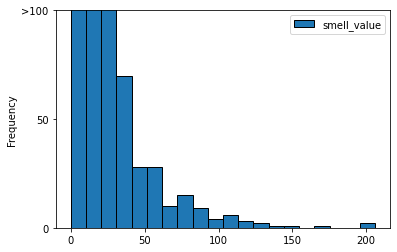

In [7]:
fig = df_smell.plot(kind="hist", bins=20, ylim=(0,100), edgecolor="black").set_yticks([0,50,100], labels=["0","50",">100"])

## Task 5: Preprocess Sensor Data

In this task, we will process the sensor data from various air quality monitoring stations in Pittsburgh. You can find the list of sensors and their names (which will be in the data frame columns) from [this link](https://github.com/CMU-CREATE-Lab/smell-pittsburgh-prediction/tree/master/dataset/v2.1#description-of-the-air-quality-sensor-data). First, we need to load all the sensor data.

In [8]:
path = "../../../assets/datasets/smellpgh-v1/esdr_raw"
list_of_files = [f for f in listdir(path) if isfile(join(path, f))]
sensor_raw_list = []
for f in list_of_files:
    sensor_raw_list.append(pd.read_csv(join(path, f)).set_index("EpochTime"))

Now, the `sensor_raw_list` variable contains all the data frames with sensor values from different air quality monitoring stations. Noted that `sensor_raw_list` is an array of data frames. We can print one of them to take a look, as shown below. 

In [9]:
sensor_raw_list[0]

,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH
EpochTime,,,,,
1477891800,0.0,0.0,51.7,343.0,3.6
1477895400,0.0,0.0,52.7,351.0,3.5
1477899000,0.0,0.0,52.6,359.0,3.4
1477902600,0.0,0.0,48.3,5.0,2.1
1477906200,0.0,0.0,31.1,41.0,2.2
...,...,...,...,...,...
1538267400,0.0,0.0,35.2,39.0,1.7
1538271000,0.0,0.0,48.2,53.0,1.3
1538274600,0.0,0.0,30.9,62.0,1.5


Next, we need to resample and merge all the sensor data frames so that they can be used for modeling. Our goal is to have a dataframe that looks like the following:

In [10]:
df_sensor = answer_preprocess_sensor(sensor_raw_list)
df_sensor

,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH,3.feed_23.CO_PPM,3.feed_23.PM10_UG_M3,3.feed_29.PM10_UG_M3,3.feed_29.PM25_UG_M3,3.feed_11067.CO_PPB..3.feed_43.CO_PPB,...,3.feed_3.SO2_PPM,3.feed_3.SONICWD_DEG,3.feed_3.SONICWS_MPH,3.feed_3.SIGTHETA_DEG,3.feed_3.PM10B_UG_M3,3.feed_5975.PM2_5,3.feed_27.NO_PPB,3.feed_27.NOY_PPB,3.feed_27.CO_PPB,3.feed_27.SO2_PPB
EpochTime,,,,,,,,,,,,,,,,,,,,,
2016-10-31 06:00:00+00:00,0.0,0.0,51.7,343.0,3.6,0.2,7.0,8.0,8.0,159.5,...,0.0,344.0,2.9,43.0,9.0,0.0,0.1,2.6,-1.0,0.2
2016-10-31 07:00:00+00:00,0.0,0.0,52.7,351.0,3.5,0.2,8.0,8.0,8.0,-1.0,...,0.0,330.0,2.5,43.6,13.0,5.0,-1.0,-1.0,106.1,0.0
2016-10-31 08:00:00+00:00,0.0,0.0,52.6,359.0,3.4,0.2,5.0,7.0,7.0,133.0,...,0.0,0.0,3.1,40.9,7.0,9.0,0.2,2.1,105.8,-1.0
2016-10-31 09:00:00+00:00,0.0,0.0,48.3,5.0,2.1,0.2,3.0,4.0,4.0,236.6,...,0.0,325.0,1.9,40.0,11.0,3.0,0.1,3.1,111.7,0.0
2016-10-31 10:00:00+00:00,0.0,0.0,31.1,41.0,2.2,0.2,5.0,5.0,4.0,269.3,...,0.0,347.0,1.4,45.1,10.0,9.0,0.1,2.5,127.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 01:00:00+00:00,0.0,0.0,35.2,39.0,1.7,0.3,20.0,15.0,10.0,455.1,...,0.0,39.0,1.3,57.3,11.0,5.0,0.1,12.1,301.0,0.0
2018-09-30 02:00:00+00:00,0.0,0.0,48.2,53.0,1.3,0.3,25.0,19.0,12.0,761.2,...,0.0,70.0,1.0,54.4,21.0,7.0,0.2,13.5,357.7,0.0
2018-09-30 03:00:00+00:00,0.0,0.0,30.9,62.0,1.5,0.4,23.0,55.0,33.0,1125.4,...,0.0,75.0,0.7,59.5,33.0,8.0,0.6,13.8,373.6,0.0


**Your task (which is your assignment) is to write a function to do the following:**
- Sensors can report in various frequencies. So, for each data frame, we need to resample the data by computing the hourly average of sensor measurements from the previous hour. (Hint: use the `pandas.DataFrame.resample` function)
- Then, merge all the data frames based on their time stamp, which is the `EpochTime` column.
- Finally, fill in the missing data with the value -1. The reason for not using 0 here is that we want the model to know if the sensor measurement has a value (including zero) or missing.

In [11]:
def preprocess_sensor(df_list):
    ###################################
    # Fill in your answer here
    return None
    ###################################

In [12]:
check_answer_df(preprocess_sensor(sensor_raw_list), df_sensor, n=1)

Test case 1 failed.

Your output is:
None

Expected output is:
                           3.feed_1.SO2_PPM  3.feed_1.H2S_PPM  \
EpochTime                                                       
2016-10-31 06:00:00+00:00               0.0               0.0   
2016-10-31 07:00:00+00:00               0.0               0.0   
2016-10-31 08:00:00+00:00               0.0               0.0   
2016-10-31 09:00:00+00:00               0.0               0.0   
2016-10-31 10:00:00+00:00               0.0               0.0   
...                                     ...               ...   
2018-09-30 01:00:00+00:00               0.0               0.0   
2018-09-30 02:00:00+00:00               0.0               0.0   
2018-09-30 03:00:00+00:00               0.0               0.0   
2018-09-30 04:00:00+00:00               0.0               0.0   
2018-09-30 05:00:00+00:00               0.0               0.0   

                           3.feed_1.SIGTHETA_DEG  3.feed_1.SONICWD_DEG  \
EpochTime        